In [1]:
import os 
import geopandas as gpd
from osgeo import gdal
import numpy as np
import numpy.ma as ma
import glob
import matplotlib.pyplot as plt
import subprocess
import earthpy as et
import earthpy.spatial as es
import rasterio as rio
from rasterio.merge import merge
from rasterio.plot import show
from rasterio.plot import plotting_extent


In [2]:
def register_array(p_arr, p_prof, t_arr, t_prof):

    '''
    #notes 
    Pick primary scene (BS)
    PS - UL [X,Y]
    
    For each scene:
        If PS[X,Y] - sUL[X,Y] ~= [+,+] and PS.shape > s.shape
            Calculate roll dimensions
            create NaN array of PS.shape
            subsitute s array 
            roll via roll dimensions
        If PS[X,Y] - sUL[X,Y] ~= [+,+] and PS.shape < s.shape
            Calculate roll dimensions
            create NaN array of PS.shape
            subsitute s array with PS.shape limits
            roll via roll dimensions
            
    '''
        
    # get the upper lefts
    ul1 = np.array([[p_prof['transform'].c, p_prof['transform'].f]])
    ul2 = np.array([[t_prof['transform'].c, t_prof['transform'].f]])

    # reset image 2 profile['transform'] to be the difference for after image reshaping
    ul_dif = ul1 - ul2
    pix_roll_dim1 = int(ul_dif[0][0]) / 0.011859917323428537 # xroll
    pix_roll_dim0 = int(ul_dif[0][1]) / 0.011859917323428537 # yroll

    # roll array then pad via array dimensions
    p_shp = np.array(p_arr.shape)
    t_shp = np.array(t_arr.shape)

    new_arr = np.ones(p_shp).astype('float64')*(-28672) # minimum value = nodata value
    
    #new_arr = t_arr
    
    # primary image has larger dimensions than target image
    if (p_shp[0] >= t_shp[0]) and (p_shp[1] >= t_shp[1]):
        
        new_arr[:t_shp[0], :t_shp[1]]= t_arr

        new_arr = np.roll(new_arr, pix_roll_dim0, axis=0)
        new_arr = np.roll(new_arr, -pix_roll_dim1, axis=1)
        
    # primary image has less rows than target image, but same or more columns    
    elif (p_shp[0] >= t_shp[0]) and (p_shp[1] < t_shp[1]):
        new_arr[:t_shp[0], :p_shp[1]]= t_arr[:t_shp[0], :p_shp[1]]

        new_arr = np.roll(new_arr, pix_roll_dim0, axis=0)
        new_arr = np.roll(new_arr, -pix_roll_dim1, axis=1)    
    
    # primary image has less columns than target image, but same or more rows
    elif (p_shp[0] < t_shp[0]) and (p_shp[1] >= t_shp[1]):
        new_arr[:p_shp[0], :t_shp[1]]= t_arr[:p_shp[0], :t_shp[1]]

        new_arr = np.roll(new_arr, pix_roll_dim0, axis=0)
        new_arr = np.roll(new_arr, -pix_roll_dim1, axis=1)
    
    # primary image has smaller dimensions than target image
    else: 
        new_arr[:p_shp[0], :p_shp[1]]= t_arr[:p_shp[0], :p_shp[1]]

        new_arr = np.roll(new_arr, pix_roll_dim0, axis=0)
        new_arr = np.roll(new_arr, -pix_roll_dim1, axis=1)
    
    return new_arr

In [3]:
# Set working directory 

os.chdir('/Users/shannonwhite/git/data/MODIS')

In [4]:
# Import boundary for plotting 

boundary_eruption = gpd.read_file(
    '/Users/shannonwhite/git/area_point_layer/POLYGON.shp')

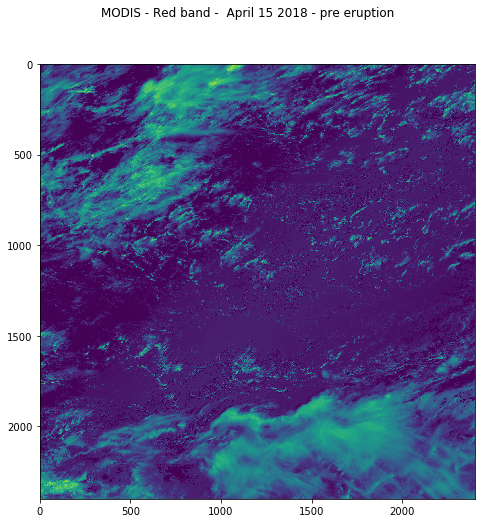

In [5]:
# Open MODIS image 

with rio.open("/Users/shannonwhite/git/data/MODIS/outputM/MOD09GA.A2018105.h03v07.006.2018107025338.2018.15.04-sd12.tif") as src4_red:
    red1 = src4_red.read()
    masked_red1 = ma.masked_where(red1== -28672, red1)
        
fig,ax1=plt.subplots(figsize=(8,8))

im=ax1.imshow(masked_red1[0])
plt.suptitle('MODIS - Red band -  April 15 2018 - pre eruption ', fontsize=12)
plt.show()

Since MODIS data is hard to determine cloud cover from quality image, and since Kilauea has a lot of cloud cover - I will instead use cloud-corrected, MODIS NDVI imagery. 

## Pre Modis 

In [6]:
# Open file

file_pre=gdal.Open('MOD13A1.A2018033.h03v07.006.2018049222534.2018.02.02.hdf')

# Look at band to select the correct band - MODIS_Grid_16DAY_500m_VI:500m 16 days NDVI
##file_pre.GetSubDatasets()

In [7]:
# Write file out from hdf to tif file

subprocess.call(["gdalwarp", "-t_srs",  "EPSG:4326",  "-overwrite", 'HDF4_EOS:EOS_GRID:"MOD13A1.A2018033.h03v07.006.2018049222534.2018.02.02.hdf":MODIS_Grid_16DAY_500m_VI:500m 16 days NDVI', "/Users/shannonwhite/git/data/MODIS/outputM/ndvi_pre2.tif"])

0

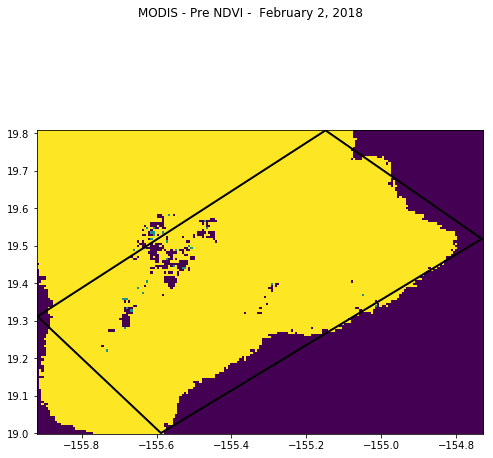

In [8]:
# Open tif file 
with rio.open("outputM/ndvi_pre2.tif") as src_ndvi_2:
    ndvi_2 = src_ndvi_2.read()
    pre_modis_meta = src_ndvi_2.profile
    
    # Crop to boundary
    ndvi_pre_crop, ndvi_pre_meta = es.crop_image(
        src_ndvi_2, boundary_eruption)

    # Scale to NDVI values 
    pre_ndvi_crop_scaled = ndvi_pre_crop*.0001

# Plot 

ndvi_extent = plotting_extent(ndvi_pre_crop[0], transform = ndvi_pre_meta['transform'])

fig,ax1=plt.subplots(figsize=(8,8))

im=ax1.imshow(ndvi_pre_crop[0], extent=ndvi_extent, vmin=-1.0, vmax=1.0)

boundary_eruption.plot(ax=ax1, color='None',
                       edgecolor='black', linewidth=2)
        
plt.suptitle('MODIS - Pre NDVI -  February 2, 2018 ', fontsize=12)
plt.show()

## Post Modis 

In [9]:
# Open file 
file_post=gdal.Open('MOD13A2.A2018225.h03v07.006.2018241235237.2018.29.08.hdf')
#file_post.GetSubDatasets()

In [10]:
# Write file out from hdf to tif file 
subprocess.call(["gdalwarp", "-t_srs",  "EPSG:4326",  "-overwrite", 'HDF4_EOS:EOS_GRID:"MOD13A2.A2018225.h03v07.006.2018241235237.2018.29.08.hdf":MODIS_Grid_16DAY_1km_VI:"1 km 16 days NDVI"', "/Users/shannonwhite/git/data/MODIS/outputM/ndvi_post2.tif"])

0

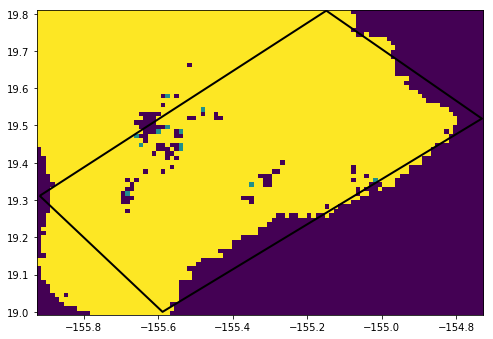

In [11]:
# Open file and det data type to float for writing out

with rio.open("outputM/ndvi_post2.tif") as src_ndvi_3:
    ndvi_3 = src_ndvi_3.read()
    post_modis_meta = src_ndvi_3.profile
    post_modis_meta['dtype']='float64'
    
    # Crop image to boundary
    ndvi_post_crop, ndvi_post_meta = es.crop_image(
        src_ndvi_3, boundary_eruption) 
    
    # Scale to NDVI values
    post_ndvi_crop_scaled = ndvi_post_crop*.0001

# Plot data     
ndvi_extent = plotting_extent(ndvi_post_crop[0], transform = ndvi_post_meta['transform'])

fig,ax1=plt.subplots(figsize=(8,8))

im=ax1.imshow(ndvi_post_crop[0], extent=ndvi_extent, vmin=-1.0, vmax=1.0)

boundary_eruption.plot(ax=ax1, color='None',
                       edgecolor='black', linewidth=2)
        

plt.show()

(array([9.430e+03, 8.000e+00, 2.614e+03, 2.096e+03, 1.584e+03, 2.039e+03,
        1.927e+03, 2.167e+03, 5.049e+03, 6.230e+02]),
 array([-0.3    , -0.17433, -0.04866,  0.07701,  0.20268,  0.32835,
         0.45402,  0.57969,  0.70536,  0.83103,  0.9567 ]),
 <a list of 10 Patch objects>)

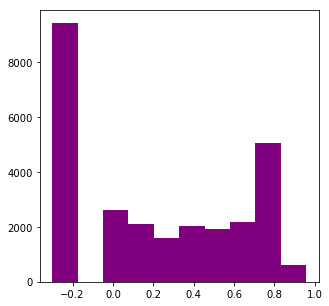

In [12]:
# View histogram - Pre NDVI 
fig, ax = plt.subplots(figsize=(5,5))
ax.hist(pre_ndvi_crop_scaled.ravel(), color='purple')


(array([2.361e+03, 2.000e+00, 9.060e+02, 7.330e+02, 5.380e+02, 5.780e+02,
        5.710e+02, 5.250e+02, 6.430e+02, 1.120e+02]),
 array([-0.3    , -0.17349, -0.04698,  0.07953,  0.20604,  0.33255,
         0.45906,  0.58557,  0.71208,  0.83859,  0.9651 ]),
 <a list of 10 Patch objects>)

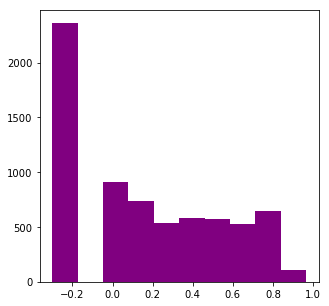

In [13]:
# View histogram - Post NDVI 
fig, ax = plt.subplots(figsize=(5,5))
ax.hist(post_ndvi_crop_scaled.ravel(), color='purple')


In [14]:
# Check shapes to calculate dNDVI

pre_ndvi_crop_scaled.shape

(1, 137, 201)

In [15]:
post_ndvi_crop_scaled.shape 

(1, 69, 101)

In [16]:
# Use function to reshape 
# Reshape pre image to fit post image

new_pre_ndvi = register_array(p_arr = post_ndvi_crop_scaled[0], p_prof = ndvi_post_meta, t_arr = pre_ndvi_crop_scaled[0], t_prof = ndvi_pre_meta)


In [17]:
# Calculate dNDVI = pre - post 

modis_dndvi = new_pre_ndvi - post_ndvi_crop_scaled[0]

# Create range for NDVI values (-1 to 1)
dndvi_range = ma.masked_outside(modis_dndvi, -1, 1)


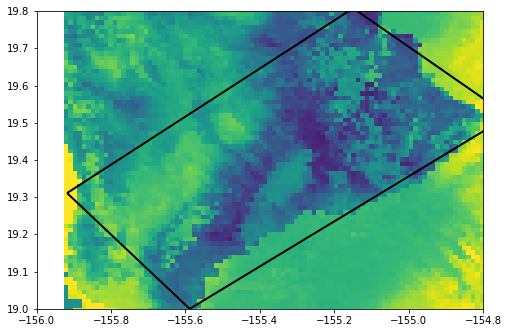

In [18]:
# Plot 

ndvi_extent = plotting_extent(ndvi_post_crop[0], transform = ndvi_post_meta['transform'])

fig,ax1=plt.subplots(figsize=(8,8))

im=ax1.imshow(modis_dndvi, extent=ndvi_extent, vmin=-1.0, vmax=1.0)

# left and right coordinate
ax1.set_xlim((-156.0, -154.8))

# bottom and top coordinate
ax1.set_ylim((19.0, 19.8))

boundary_eruption.plot(ax=ax1, color='None',
                       edgecolor='black', linewidth=2)
        

plt.show()

(array([ 183.,  390.,  645.,  621.,  869.,  884., 1763.,  545.,  452.,
         471.]),
 array([-0.8433 , -0.65908, -0.47486, -0.29064, -0.10642,  0.0778 ,
         0.26202,  0.44624,  0.63046,  0.81468,  0.9989 ]),
 <a list of 10 Patch objects>)

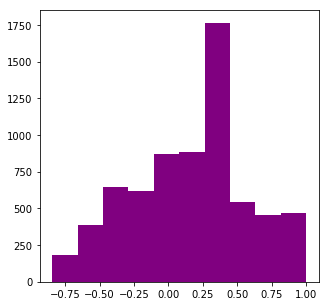

In [19]:
# Plot histogram with range values 

fig, ax = plt.subplots(figsize=(5,5))
ax.hist(dndvi_range.ravel(), color='purple')

In [20]:
# Write out dNDVI 
out_path_dndvi = '/Users/shannonwhite/git/data/MODIS/outputM/modis_dndvi.tif'

with rio.open(out_path_dndvi,"w",**post_modis_meta) as dest:
    dest.write(modis_dndvi,1)